# Misunderstandings! In the Emergency Room.*

( * A bad Panic! At the Disco Reference. )

## Setup

As always, let's import the packages we need and set a random seed in numpy. If you want to run this with truly random data, just comment out the `np.random.seed()` line.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

## Simulate our dataset

In [36]:
n_patients = 1000

# Generate ages from a gamma distribution, scaled and truncated to 18-99
ages = (np.random.gamma(3, 8, n_patients) + 18).astype(int)
ages = np.clip(ages, 18, 98)

baseline_adverse_rate = 0.20
adverse_events = np.random.random(n_patients) < baseline_adverse_rate

df = pd.DataFrame({
    'age': ages,
    'adverse_event': adverse_events.astype(int)
})

# Now inject the problematic data: unknown ages coded as 99
n_unknown = 50  # 5% of patients have unknown age
unknown_indices = np.random.choice(df.index, n_unknown, replace=False)

# These patients have much higher adverse event rate (80%)
df.loc[unknown_indices, 'age'] = 99
df.loc[unknown_indices, 'adverse_event'] = (np.random.random(n_unknown) < 0.80).astype(int)

df.head(10)

,age,adverse_event
0,46,0
1,37,0
2,36,0
3,36,0
4,67,0
5,51,0
6,99,1
7,47,0
8,42,1
9,22,0


First, we'll recreate the naive analysis, simply looking to see if we find different rates of adverse events if we bin by age:

In [33]:
print(df.groupby(pd.cut(df['age'], bins=[18, 40, 60, 80, 99]), observed=True)['adverse_event'].mean())

age
(18, 40]    0.177950
(40, 60]    0.183099
(60, 80]    0.279412
(80, 99]    0.733333
Name: adverse_event, dtype: float64


The problem becomes obvious when we look at the age distribution:

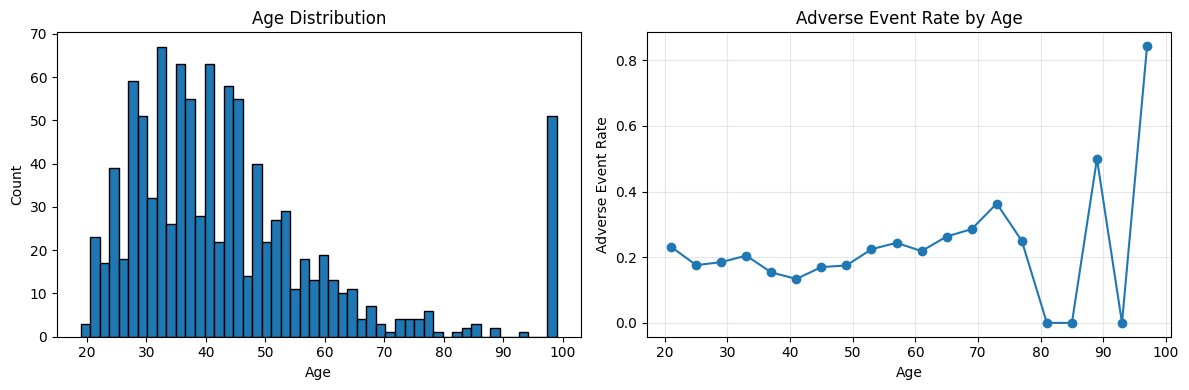

In [32]:
# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Age distribution
axes[0].hist(df['age'], bins=50, edgecolor='black')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Age Distribution')

# Adverse event rate by age
age_bins = pd.cut(df['age'], bins=20)
adverse_by_age = df.groupby(age_bins, observed=True)['adverse_event'].mean()

# Get the midpoint of each age bin for plotting
bin_midpoints = [interval.mid for interval in adverse_by_age.index]

axes[1].plot(bin_midpoints, adverse_by_age.values, 'o-')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Adverse Event Rate')
axes[1].set_title('Adverse Event Rate by Age')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In this case, we should exclude all of the patients whose ages are exactly 99. Unfortunately, this means we will also loose people who were legitimately 99 years old -- underscoring the importance of smartly choosing ways to encode missing values (e.g., with NaN).

In [34]:
df_clean = df[df['age'] != 99] # filter out anyone whose age is equal to 99
print(df.groupby(pd.cut(df_clean['age'], bins=[18, 40, 60, 80, 99]), observed=True)['adverse_event'].mean())

age
(18, 40]    0.177950
(40, 60]    0.183099
(60, 80]    0.279412
(80, 99]    0.200000
Name: adverse_event, dtype: float64


As you can see, now the rate of adverse events is much more even across ages once we exclude those individuals that were erroneously coded with 99.